In [1]:
from google.colab import files

uploaded = files.upload()


Saving data.zip to data.zip


In [2]:
import zipfile
import os

zip_path = "data.zip"
extract_path = "."

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")


Extraction completed!


In [ ]:
import os

for root, dirs, files in os.walk("data"):
    print(root, "->", len(files), "files")


data -> 0 files
data/watermark -> 3 files
data/host -> 941 files


In [3]:
# ===================== INSTALL =====================
!pip install pytorch_wavelets pytorch-msssim --quiet

# ===================== IMPORTS =====================
import os, random, torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== DATASET =====================
class WatermarkDataset(Dataset):
    def __init__(self, host_dir, wm_dir):
        self.hosts = [os.path.join(host_dir,f) for f in os.listdir(host_dir)]
        self.wms   = [os.path.join(wm_dir,f) for f in os.listdir(wm_dir)]

        self.ht = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()
        ])
        self.wt = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hosts)

    def __getitem__(self, i):
        host = Image.open(self.hosts[i]).convert("RGB")
        wm   = Image.open(random.choice(self.wms))
        return self.ht(host), self.wt(wm)

# ===================== EMBEDDER =====================
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32+3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        fused = self.fuse(torch.cat([LH, wm_f], 1))
        Yh_new = torch.stack([fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2)

        out = self.idwt((Yl, [Yh_new]))
        return torch.clamp(out, 0, 1)

# ===================== EXTRACTOR (BLIND) =====================
class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        return self.net(Yh[0][:,:,0])

# ===================== ATTACK =====================
def attack(img):
    if random.random() < 0.5:
        img = img + 0.01 * torch.randn_like(img)
    return torch.clamp(img, 0, 1)

# ===================== TRAINING =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = WatermarkDataset("data/host", "data/watermark")
loader  = DataLoader(dataset, batch_size=8, shuffle=True)

E = Embedder().to(device)
X = Extractor().to(device)

opt = optim.Adam(list(E.parameters()) + list(X.parameters()), lr=1e-4)

for epoch in range(80):
    for host, wm in loader:
        host, wm = host.to(device), wm.to(device)

        wimg = E(host, wm)
        wimg_a = attack(wimg)
        wm_pred = X(wimg_a)

        L_img = nn.functional.mse_loss(wimg, host)
        L_wm  = nn.functional.mse_loss(wm_pred, wm)
        L_ssim = 1 - ssim(wimg, host, data_range=1)

        loss = L_img + 6*L_wm + 0.5*L_ssim

        opt.zero_grad()
        loss.backward()
        opt.step()

    psnr = 10 * torch.log10(1 / L_img)
    print(f"Epoch {epoch+1:03d} | Loss {loss:.4f} | PSNR {psnr:.2f}")

# ===================== SAVE =====================
torch.save(E.state_dict(), "embedder.pth")
torch.save(X.state_dict(), "extractor.pth")

print("✅ Training complete. Models saved.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.8 MB/s eta 0:00:00
Epoch 001 | Loss 0.4492 | PSNR 30.76
Epoch 002 | Loss 0.6181 | PSNR 31.47
Epoch 003 | Loss 0.3326 | PSNR 29.26
Epoch 004 | Loss 0.5165 | PSNR 29.93
Epoch 005 | Loss 0.4234 | PSNR 29.84
Epoch 006 | Loss 0.3466 | PSNR 29.83
Epoch 007 | Loss 0.2365 | PSNR 30.80
Epoch 008 | Loss 0.3397 | PSNR 31.35
Epoch 009 | Loss 0.3470 | PSNR 31.40
Epoch 010 | Loss 0.2226 | PSNR 29.28
Epoch 011 | Loss 0.2773 | PSNR 29.82
Epoch 012 | Loss 0.2407 | PSNR 28.82
Epoch 013 | Loss 0.2129 | PSNR 30.91
Epoch 014 | Loss 0.2902 | PSNR 30.17
Epoch 015 | Loss 0.2001 | PSNR 29.76
Epoch 016 | Loss 0.1985 | PSNR 31.42
Epoch 017 | Loss 0.2270 | PSNR 31.57
Epoch 018 | Loss 0.2460 | PSNR 29.45
Epoch 019 | Loss 0.2187 | PSNR 31.50
Epoch 020 | Loss 0.1603 | PSNR 31.72
Epoch 021 | Loss 0.1952 | PSNR 29.39
Epoch 022 | Loss 0.1906 | PSNR 30.12
Epoch 023 | Loss 0.1539 | PSNR 30.62
Epoch 024 | Loss 0.1861 | PSNR 31.19
Epoch 025 | Loss 0.2011 | PSNR 28.

📤 Upload HOST image


Saving 6 - Copy (6) - Copy.png to 6 - Copy (6) - Copy.png
📤 Upload WATERMARK image


Saving images.png to images.png
📊 PSNR : 29.12 dB
📊 SSIM : 0.8583


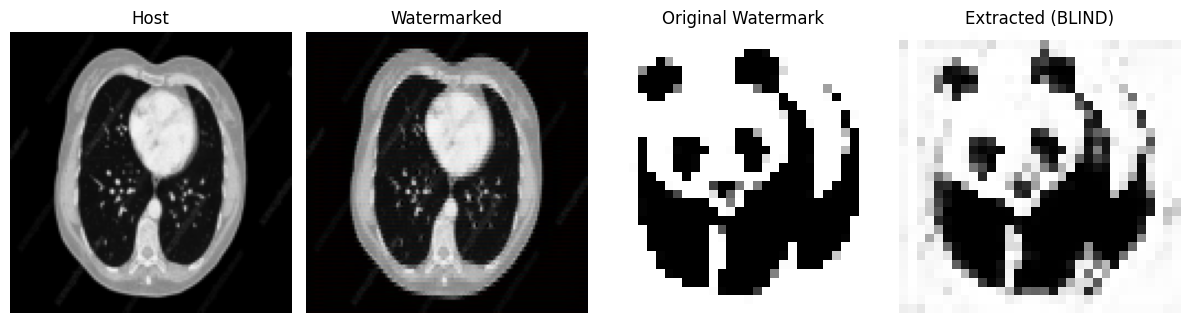

In [5]:
# ===================== IMPORTS =====================
import torch, os
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from google.colab import files
from pytorch_wavelets import DWTForward, DWTInverse
from pytorch_msssim import ssim

# ===================== UPLOAD IMAGES =====================
print("📤 Upload HOST image")
host_upload = files.upload()
host_path = list(host_upload.keys())[0]

print("📤 Upload WATERMARK image")
wm_upload = files.upload()
wm_path = list(wm_upload.keys())[0]

# ===================== MODELS =====================
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt  = DWTForward(J=1, wave='haar')
        self.idwt = DWTInverse(wave='haar')

        self.wm_enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU()
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(35, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1)
        )

    def forward(self, host, wm):
        Yl, Yh = self.dwt(host)
        LH = Yh[0][:,:,0]

        wm_f = self.wm_enc(wm)
        wm_f = nn.functional.interpolate(wm_f, size=LH.shape[-2:])

        fused = self.fuse(torch.cat([LH, wm_f], 1))
        Yh_new = torch.stack([fused, Yh[0][:,:,1], Yh[0][:,:,2]], 2)

        out = self.idwt((Yl, [Yh_new]))
        return torch.clamp(out, 0, 1)

class Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.dwt = DWTForward(J=1, wave='haar')
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((32,32)),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        _, Yh = self.dwt(x)
        return self.net(Yh[0][:,:,0])

# ===================== LOAD MODELS =====================
device = "cuda" if torch.cuda.is_available() else "cpu"

E = Embedder().to(device)
X = Extractor().to(device)

E.load_state_dict(torch.load("embedder.pth", map_location=device))
X.load_state_dict(torch.load("extractor.pth", map_location=device))

E.eval()
X.eval()

# ===================== TRANSFORMS =====================
host_tf = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

wm_tf = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

host = host_tf(Image.open(host_path).convert("RGB")).unsqueeze(0).to(device)
wm   = wm_tf(Image.open(wm_path)).unsqueeze(0).to(device)

# ===================== EMBED & EXTRACT =====================
with torch.no_grad():
    watermarked = E(host, wm)
    extracted_wm = X(watermarked)

# ===================== METRICS =====================
mse = nn.functional.mse_loss(watermarked, host)
psnr = 10 * torch.log10(1 / mse)
ssim_val = ssim(watermarked, host, data_range=1)

print(f"📊 PSNR : {psnr:.2f} dB")
print(f"📊 SSIM : {ssim_val:.4f}")

# ===================== VISUALIZATION =====================
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(host[0].permute(1,2,0).cpu())
plt.title("Host")
plt.axis("off")


plt.subplot(1,4,2)
plt.imshow(watermarked[0].permute(1,2,0).cpu())
plt.title("Watermarked")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(wm[0][0].cpu(), cmap="gray")
plt.title("Original Watermark")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(extracted_wm[0][0].cpu(), cmap="gray")
plt.title("Extracted (BLIND)")
plt.axis("off")

plt.tight_layout()
plt.show()
